### Install required packages for training model


In [2]:
'''
!pip install gensim --upgrade
!pip install tensorflow-gpu --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install scikit-learn --upgrade
'''

'\n!pip install gensim --upgrade\n!pip install tensorflow-gpu --upgrade\n!pip install keras --upgrade\n!pip install pandas --upgrade\n!pip install scikit-learn --upgrade\n'

### Import packages

In [3]:
# DataFrame
import pandas as pd

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

# Utils
import re
import numpy as np
import pickle
import itertools

# Plots
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation

### Import Data

In [4]:
# Read raw dataset
dataset_columns = ["sentiment", "ids", "date", "flag", "user", "text"]
dataset_encoding = "ISO-8859-1"
dataset = pd.read_csv('dataset/training.1600000.processed.noemoticon.csv',
                      encoding=dataset_encoding , names=dataset_columns)

# Removing the unnecessary columns.
dataset = dataset[['sentiment', 'text']]

# Replace value 4 with 1 (positive)
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)

# Dataset result
dataset.head(3)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...


In [5]:
# Dataset distribution
dataset.groupby('sentiment').count()

,text
sentiment,
0,800000
1,800000


### Pre-Process dataset

In [6]:
# Load Enlgish contraction dictionary
contractions = pd.read_csv('dataset/contractions.csv', index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']

# Define stop words
stopwords_list = pd.read_csv('dataset/stopwords.csv', names=['Stopwords'])['Stopwords']
stopwords_list = list(stopwords_list)

# Define text cleaning pattern
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Define emojis cleaning pattern
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

In [7]:
def preprocess(text):
    
    # 1, Convert to lower case
    text = text.lower()

    # 2, Replace all URls with '<url>'
    text = re.sub(urlPattern, '<url>', text)
    
    # 3, Replace all @USERNAME to '<user>'.
    text = re.sub(userPattern, '<user>', text)
    
    # 4, Replace 3 or more consecutive letters by 2 letter.
    text = re.sub(sequencePattern, seqReplacePattern, text)

    # 5, Replace all emojis.
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(smileemoji, '<smile>', text)
    text = re.sub(sademoji, '<sadface>', text)
    text = re.sub(neutralemoji, '<neutralface>', text)
    text = re.sub(lolemoji, '<lolface>', text)

    # 6, Remove Contractions
    for contraction, replacement in contractions_dict.items():
        text = text.replace(contraction, replacement)

    # 7, Remove stop words
    text = ' '.join([word for word in text.split() if word not in stopwords_list])
    
    # 8, Removing Non-Alphabets and replace them with a space
    text = re.sub(alphaPattern, ' ', text)

    # 9, Adding space on either side of '/' to seperate words.
    text = re.sub(r'/', ' / ', text)
    
    return text

In [8]:
# Show processed result of a sample text
sample_text = dataset.iloc[2]["text"]
print("Original  Text: ", sample_text)
print("Processed Text: ", preprocess(sample_text))

Original  Text:  @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed Text:  <user> dived many times ball  managed save 50  rest go bounds


In [9]:
# Clean up the text and store it in a new field
dataset['processed_text'] = dataset.text.apply(preprocess)

# Convert it to numpy
X_data, y_data = np.array(dataset['processed_text']), np.array(dataset['sentiment'])

### Split training and testing set

In [10]:
# Spliting train test set
text_X_train, text_X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.05, 
                                                              random_state=0, stratify=y_data)
print("Training set size:", len(y_train))
print("Testing set size:", len(y_test))

Training set size: 1520000
Testing set size: 80000


### Word embedding

In [11]:
# TF-IDF Vectorizer
vectoriser = TfidfVectorizer(max_features=100000)
vectoriser.fit(text_X_train)

TfidfVectorizer(max_features=100000)

In [12]:
# Vectorize data
X_train = vectoriser.transform(text_X_train)
X_test  = vectoriser.transform(text_X_test)

# Model Training

In [13]:
def plot_confusion_matrix(y_test, y_pred):
    # Compute and plot the Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    
    classes  = ['Positive', 'Negative']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 fontsize = 12,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.title('Confusion Matrix', fontsize=20)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

### Naive Bayes

In [14]:
# Training
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)

BernoulliNB()

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     40000
           1       0.78      0.79      0.78     40000

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000



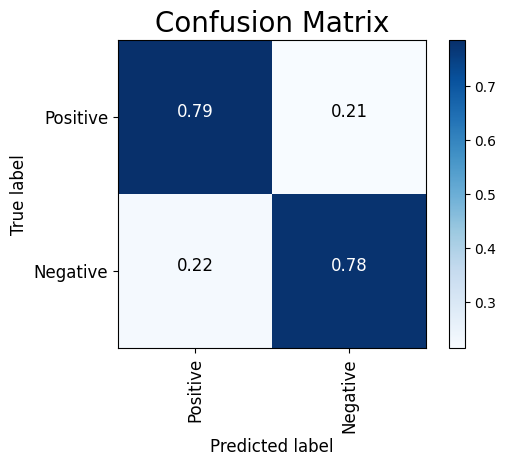

In [15]:
# Testing
y_pred = BNBmodel.predict(X_test)

plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

### Logistic Regression

In [16]:
# Training
LRmodel = LogisticRegression(C=1, max_iter=1000)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=1000)

              precision    recall  f1-score   support

           0       0.81      0.78      0.80     40000
           1       0.79      0.81      0.80     40000

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



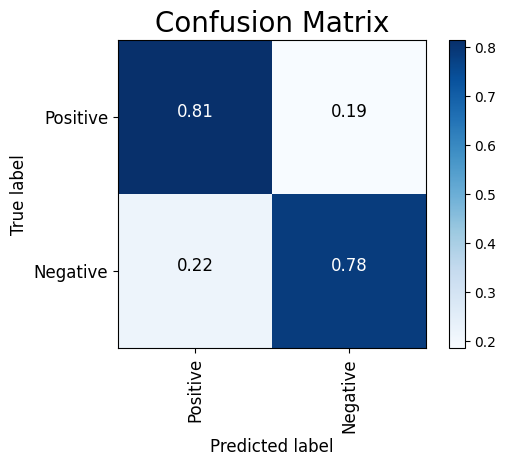

In [17]:
# Testing
y_pred = LRmodel.predict(X_test)

plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

### SVM

In [18]:
# Training
# SVCmodel = SVC(C=1.0, kernel='rbf') # This takes forever to train...
SVCmodel = LinearSVC(C=0.5)
SVCmodel.fit(X_train, y_train)

LinearSVC(C=0.5)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     40000
           1       0.79      0.81      0.80     40000

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



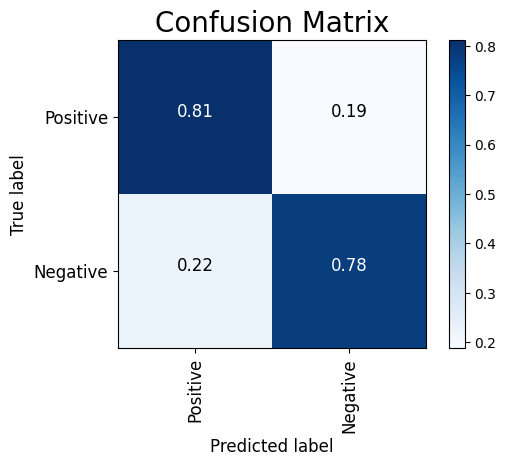

In [19]:
# Testing
y_pred = SVCmodel.predict(X_test)

plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

# Save Model

In [ ]:
import os
if not os.path.exists('models'):
    os.makedirs('models')

model_path ='models/BNB.sav'
pickle.dump(BNBmodel, open(model_path, 'wb'))

model_path ='models/LR.sav'
pickle.dump(LRmodel, open(model_path, 'wb'))

model_path ='models/SVC.sav'
pickle.dump(SVCmodel, open(model_path, 'wb'))